In [1]:
import os, cv2
import numpy as np
import pandas as pd

from scipy import ndimage
from skimage import measure
from matplotlib import pyplot as plt
%matplotlib inline


def process_segmented_lung(segmented_lung, threshold=0.5, region_count=[1, 2], need_ratio_feature=False):
    processed_img = np.zeros_like(segmented_lung)
    ratio_feature = []
    for i in range(len(region_count)):
        region_mask = segmented_lung[i, ...] > 0.5
        label_im, nb_labels = ndimage.label(region_mask)
        if nb_labels == 0:
            continue
        else:
            mask_point_count = ndimage.sum(region_mask, label_im, range(nb_labels + 1)) / np.prod(region_mask.shape)
            sorted_index = np.argsort(mask_point_count) 

            if len(sorted_index) >= region_count[i]:
                sorted_index = sorted_index[-region_count[i]:]
            processed_img[i, ...] = ndimage.binary_fill_holes(np.isin(label_im, sorted_index) * region_mask)
        ratio_feature.extend(mask_point_count[sorted_index])
        
    if need_ratio_feature:
        return processed_img, ratio_feature
    else:
        return processed_img

def extract_position_feature(processed_mask):
    def normalize(distance):
        return distance / distance.max()

    distance_feature = np.zeros((4, 512, 512))
    for i in range(len(processed_mask)):
        temp_distance = ndimage.morphology.distance_transform_edt(processed_mask[i, ...])
        temp_distance_1 = ndimage.morphology.distance_transform_edt(1-processed_mask[i, ...])
        distance_feature[i*2, ...] = normalize(temp_distance)
        distance_feature[i*2+1, ...] = normalize(temp_distance_1)
    return distance_feature

In [2]:
# root_path = '...'
df = pd.read_csv('/data1/pengchengtao/Chest X-ray disease/csv/labels_v14_v2.csv')
# 共112119个病人样本+标签

In [3]:
print(df)

             Image Index  Patient ID  Patient Age Patient Gender  \
0       00000001_000.png           1           58              M   
1       00000001_001.png           1           58              M   
2       00000001_002.png           1           58              M   
3       00000002_000.png           2           81              M   
4       00000003_000.png           3           81              F   
5       00000003_001.png           3           74              F   
6       00000003_002.png           3           75              F   
7       00000003_003.png           3           76              F   
8       00000003_004.png           3           77              F   
9       00000003_005.png           3           78              F   
10      00000003_006.png           3           79              F   
11      00000003_007.png           3           80              F   
12      00000004_000.png           4           82              M   
13      00000005_000.png           5           6

In [3]:
num = 112094

In [4]:
df.iloc[num]

Image Index           00030786_004.png
Patient ID                       30786
Patient Age                         61
Patient Gender                       F
View Position                       AP
Atelectasis                          0
Cardiomegaly                         1
Effusion                             1
Infiltration                         0
Mass                                 0
Nodule                               0
Pneumonia                            0
Pneumothorax                         1
Consolidation                        0
Edema                                0
Emphysema                            1
Fibrosis                             0
Pleural_Thickening                   0
Hernia                               0
Name: 112094, dtype: object

In [5]:
#112094
IMAGE_NAME = df['Image Index'].values[num]

In [6]:
image = cv2.imread(os.path.join('/data1/pengchengtao/Chest X-ray disease/Chest_x_ray8/images/{}'.format(IMAGE_NAME)))

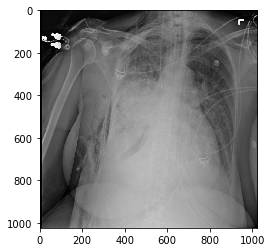

In [7]:
plt.imshow(image)

In [8]:
MASK_PATH = '/data1/pengchengtao/Chest X-ray disease/Chest_Mask/'
mask_path = os.path.join(MASK_PATH, IMAGE_NAME.replace('.png', '_mask.npy'))
mask = np.load(mask_path)

In [9]:
processed_mask = process_segmented_lung(mask)
position_feature = extract_position_feature(processed_mask)

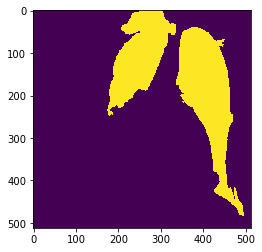

In [11]:
plt.imshow(processed_mask[1, ...])

In [156]:
processed_mask.shape

(2, 512, 512)

In [157]:
position_feature.shape

(4, 512, 512)

In [170]:
feature = np.vstack((processed_mask, position_feature))

In [171]:
ratio = 0.5
feature = np.clip(ndimage.interpolation.zoom(feature, [1, ratio, ratio]), 0, 1)

In [172]:
feature.shape

(6, 256, 256)

In [173]:
np.save('/mnt/eb130be7-e0eb-43fb-93a9-49f84c94a92b/test.npy', feature)

In [21]:
import numpy as np
import matplotlib.image as mpimg

In [22]:
test0 = mpimg.imread('/data1/pengchengtao/Chest X-ray disease/Chest_x_ray8/images/00000001_000.png')

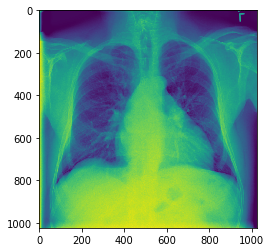

In [23]:
plt.imshow(test0)

In [6]:
test = np.load('/data1/pengchengtao/Chest X-ray disease/process_feature/00000001_000_mask_feature.npy')

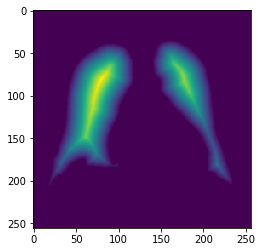

In [7]:
plt.imshow(test[4, ...])

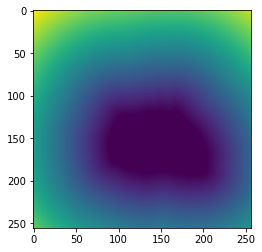

In [8]:
plt.imshow(test[3, ...])

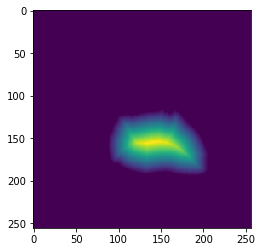

In [9]:
plt.imshow(test[2, ...])

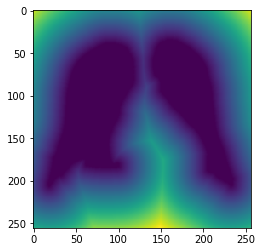

In [11]:
plt.imshow(test[5, ...])

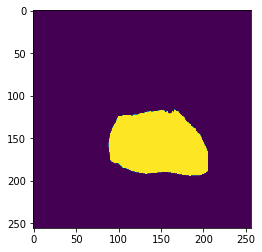

In [12]:
plt.imshow(test[0, ...])

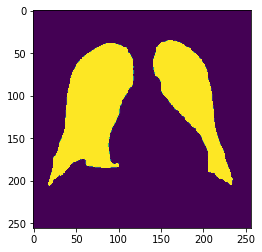

In [13]:
plt.imshow(test[1, ...])

In [5]:
test.shape

(6, 256, 256)